## Transfer Learning

Let's pick a well-trained model and see how it did on the test data:

In [1]:
import os
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tools.train as train
import tools.plot as plot

Using TensorFlow backend.



Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64
Confusion matrix, without normalization
[[18070    20    24     2     2]
 [  152   395     9     0     0]
 [   68     6  1353    17     4]
 [   40     0    13   109     0]
 [   60     0     6     0  1542]]


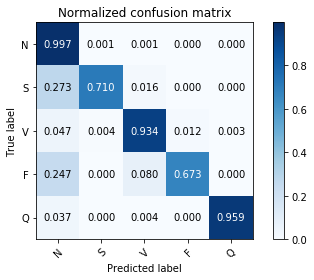

In [2]:
# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Count data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs_mit, labels_mit, sparse_labels_mit, df_mit = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs_mit:
    inputs_mit[key] = tf.expand_dims(inputs_mit[key], axis=2)
train.class_count(df_mit)

# Load in a model
modelpath = os.path.join("..", "models", "20190812-181641", "nofft", "wavenet.h5") # A specific run on Jeffmin's computer
model = tf.keras.models.load_model(modelpath)

# See model performance
test_pred = np.argmax(model.predict(inputs_mit["test"]), axis=1)
plot.plot_cm(sparse_labels_mit["test"], test_pred, classes=np.array(["N", "S", "V", "F", "Q"]), normalize=True)

Now we'll freeze all of the layers in the model except for the last classifying (dense) layer.

In [3]:
for layer in model.layers[:-1]:
    layer.trainable = False

# Put in a dummy compile to see the frozen layers
model.compile(optimizer="Nadam", loss="categorical_crossentropy")
model.summary()

Model: "conv1d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 187, 94)      188         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 187, 94)      17766       conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 187, 94)      17766       conv1d[0][0]                     
_____________________________________________________________________________________________

__________________________________________________________________________________________________
multiply_6 (Multiply)           (None, None, 94)     0           conv1d_19[0][0]                  
                                                                 conv1d_20[0][0]                  
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, None, 94)     8930        multiply_6[0][0]                 
__________________________________________________________________________________________________
add_6 (Add)                     (None, 187, 94)      0           conv1d_21[0][0]                  
                                                                 add_5[0][0]                      
__________________________________________________________________________________________________
add_7 (Add)                     (None, 187, 94)      0           add_6[0][0]                      
          

Let's split the PTB dataset into train and test sets (if we haven't already) and load them in with our custom API:

In [4]:
train.split_test_train(
    ["../data/ptbdb_abnormal.csv", "../data/ptbdb_normal.csv"],
    os.path.join("..", "data", "ptbdb"),
    0.2,
)

# Count data
files = ("../data/ptbdb_train.csv", "../data/ptbdb_test.csv")
inputs_ptb, labels_ptb, sparse_labels_ptb, df_ptb = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs_ptb:
    inputs_ptb[key] = tf.expand_dims(inputs_ptb[key], axis=2)
train.class_count(df_ptb)


Train set
Count of each class
Classes
0.0     4046
1.0    10506
dtype: int64

Test set
Count of each class
Classes
0.0     809
1.0    2101
dtype: int64


Now let's use the flattened convolutional output as input to a few fully-connected layers, and train the mostly-frozen model on the new data (we'll apply weights to the loss function due to the imbalanced dataset):

In [5]:
largest_class_count = df_ptb["train"].groupby("Classes").size().max()
class_weights = np.divide(largest_class_count, df_ptb["train"].groupby("Classes").size().to_numpy())

print("Weighting the classes:", class_weights)

config = {
    "optimizer": "Nadam",
    "loss": "binary_crossentropy",
    "class_weights": class_weights,
    "batch_size": 50,
    "val_split": 0.1,
    "epochs": 500,
    "verbose": 0,
    "patience": 50,
    "progbar": True,
    "metrics": ["accuracy"],
    "regularizer": regularizers.l1_l2(l1=0.001, l2=0.01),
}

conv_output = model.layers[-2].output
new_output = layers.Dense(94, activation="relu", kernel_regularizer=config.get("regularizer"))(conv_output)
new_output = layers.Dense(94, activation="relu", kernel_regularizer=config.get("regularizer"))(new_output)
new_output = layers.Dropout(0.8, name="transfer_dropout")(new_output)
new_output = layers.Dense(1, activation="sigmoid")(new_output)
transferred_model = tf.keras.Model(inputs=model.layers[0].input, outputs=new_output, name="transferred_conv1d")

# Train it
history = train.train_print(transferred_model, inputs_ptb, sparse_labels_ptb, config)

Weighting the classes: [2.59663866 1.        ]
Model: "transferred_conv1d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 187, 94)      188         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 187, 94)      17766       conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 187, 94)      17766       conv1d[0][0]                     
__________________________________

__________________________________________________________________________________________________
multiply_6 (Multiply)           (None, None, 94)     0           conv1d_19[0][0]                  
                                                                 conv1d_20[0][0]                  
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, None, 94)     8930        multiply_6[0][0]                 
__________________________________________________________________________________________________
add_6 (Add)                     (None, 187, 94)      0           conv1d_21[0][0]                  
                                                                 add_5[0][0]                      
__________________________________________________________________________________________________
add_7 (Add)                     (None, 187, 94)      0           add_6[0][0]                      
          


Train acc: 0.9865311
Test acc: 0.98591065


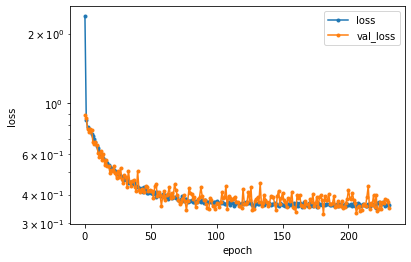

Confusion matrix, without normalization
[[ 792   17]
 [  24 2077]]


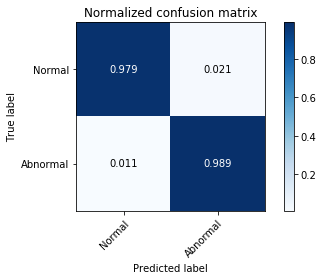

In [6]:
plot.plot_fit_history(history)

test_pred = transferred_model.predict(inputs_ptb["test"])
test_pred[test_pred > 0.5] = 1
test_pred[test_pred <= 0.5] = 0
plot.plot_cm(sparse_labels_ptb["test"], test_pred, classes=np.array(["Normal", "Abnormal"]), normalize=True)